In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, fowlkes_mallows_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, train_test_split
from Config import df

In [2]:
def process_data(data):
    df = data.copy()
    cards = df[["C1", "C2", "C3", "C4", "C5"]]
    suits = df[["S1", "S2", "S3", "S4", "S5"]]
    cards.values.sort()
    suits.values.sort()
    df[["C1", "C2", "C3", "C4", "C5"]] = cards
    df[["S1", "S2", "S3", "S4", "S5"]] = suits
    df = df[["S1", "C1","S2", "C2","S3", "C3","S4", "C4","S5", "C5"]]
    df = add_counts(df)
    df = add_diffs(df)
    df = add_unique_count(df)
    return df

In [3]:
def add_counts(df):
    tmp_card = df[["C1", "C2", "C3", "C4", "C5"]]
    tmp_suit = df[["S1", "S2", "S3", "S4", "S5"]]
    #counts how many like cards are in the row, exposes the relationship required for pairs, sets, and quads.
    df["cnt_c1"] = tmp_card.apply(lambda c: sum(c==c[0]), axis=1)
    df["cnt_c2"] = tmp_card.apply(lambda c: sum(c==c[1]), axis=1)
    df["cnt_c3"] = tmp_card.apply(lambda c: sum(c==c[2]), axis=1)
    df["cnt_c4"] = tmp_card.apply(lambda c: sum(c==c[3]), axis=1)
    df["cnt_c5"] = tmp_card.apply(lambda c: sum(c==c[4]), axis=1)
    #counts how many like suits are in the row, allows for easy tracking of flushes
    df["cnt_s1"] = tmp_suit.apply(lambda s: sum(s==s[0]), axis=1)
    df["cnt_s2"] = tmp_suit.apply(lambda s: sum(s==s[1]), axis=1)
    df["cnt_s3"] = tmp_suit.apply(lambda s: sum(s==s[2]), axis=1)
    df["cnt_s4"] = tmp_suit.apply(lambda s: sum(s==s[3]), axis=1)
    df["cnt_s5"] = tmp_suit.apply(lambda s: sum(s==s[4]), axis=1)
    return df

In [4]:
def add_diffs(df):
    tmp = df
    #Calculates the difference between cards to determine if a straight is possible
    df["diff_1"] = tmp["C2"] - tmp["C1"]
    df["diff_2"] = tmp["C3"] - tmp["C2"]
    df["diff_3"] = tmp["C4"] - tmp["C3"]
    df["diff_4"] = tmp["C5"] - tmp["C4"]
    #Counts how many similar differences there are. Should improve straight detection, and pair detection
    tmp_diff = df[["diff_1","diff_2","diff_3","diff_4"]]
    df["cnt_diff1"] = tmp_diff.apply(lambda c: sum(c==c[0]), axis=1)
    df["cnt_diff2"] = tmp_diff.apply(lambda c: sum(c==c[1]), axis=1)
    df["cnt_diff3"] = tmp_diff.apply(lambda c: sum(c==c[2]), axis=1)
    df["cnt_diff4"] = tmp_diff.apply(lambda c: sum(c==c[3]), axis=1)
    return df

In [5]:
def add_unique_count(df):
    tmp_suit = df[["S1", "S2", "S3", "S4", "S5"]]
    df["unique_suit"] = tmp_suit.apply(lambda s: len(np.unique(s)), axis=1)
    return df

In [18]:
x_train = df.iloc[:,:-1]
x_train = process_data(x_train)
y_train = df.iloc[:,-1]
x_train

/var/folders/zn/ryhys7_x53v5s813c52yppd40000gn/T/ipykernel_61210/3620088690.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df["cnt_c1"] = tmp_card.apply(lambda c: sum(c==c[0]), axis=1)
/var/folders/zn/ryhys7_x53v5s813c52yppd40000gn/T/ipykernel_61210/3620088690.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df["cnt_c2"] = tmp_card.apply(lambda c: sum(c==c[1]), axis=1)
/var/folders/zn/ryhys7_x53v5s813c52yppd40000gn/T/ipykernel_61210/3620088690.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Da

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,...,cnt_s5,diff_1,diff_2,diff_3,diff_4,cnt_diff1,cnt_diff2,cnt_diff3,cnt_diff4,unique_suit
0,1,1,1,10,1,11,1,12,1,13,...,5,9,1,1,1,1,3,3,3,1
1,2,1,2,10,2,11,2,12,2,13,...,5,9,1,1,1,1,3,3,3,1
2,3,1,3,10,3,11,3,12,3,13,...,5,9,1,1,1,1,3,3,3,1
3,4,1,4,10,4,11,4,12,4,13,...,5,9,1,1,1,1,3,3,3,1
4,4,1,4,10,4,11,4,12,4,13,...,5,9,1,1,1,1,3,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025005,1,1,2,6,2,9,3,9,4,12,...,1,5,3,0,3,1,2,1,2,4
1025006,1,3,2,3,3,4,4,5,4,7,...,2,0,1,1,2,1,2,2,1,4
1025007,1,7,1,7,2,9,3,11,4,13,...,1,0,2,2,2,1,3,3,3,4
1025008,1,1,1,8,2,8,3,11,3,13,...,2,7,0,3,2,1,1,1,1,3


In [25]:
x_train.to_csv("x_train_diferencias_sumas.csv")

In [10]:
X = pd.read_csv('x_train_diferencias_sumas.csv', index_col=0)
y = df['CLASS']
X

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,...,cnt_s5,diff_1,diff_2,diff_3,diff_4,cnt_diff1,cnt_diff2,cnt_diff3,cnt_diff4,unique_suit
0,1,1,1,10,1,11,1,12,1,13,...,5,9,1,1,1,1,3,3,3,1
1,2,1,2,10,2,11,2,12,2,13,...,5,9,1,1,1,1,3,3,3,1
2,3,1,3,10,3,11,3,12,3,13,...,5,9,1,1,1,1,3,3,3,1
3,4,1,4,10,4,11,4,12,4,13,...,5,9,1,1,1,1,3,3,3,1
4,4,1,4,10,4,11,4,12,4,13,...,5,9,1,1,1,1,3,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025005,1,1,2,6,2,9,3,9,4,12,...,1,5,3,0,3,1,2,1,2,4
1025006,1,3,2,3,3,4,4,5,4,7,...,2,0,1,1,2,1,2,2,1,4
1025007,1,7,1,7,2,9,3,11,4,13,...,1,0,2,2,2,1,3,3,3,4
1025008,1,1,1,8,2,8,3,11,3,13,...,2,7,0,3,2,1,1,1,1,3


In [21]:
X.iloc[0]

S1              1
C1              1
S2              1
C2             10
S3              1
C3             11
S4              1
C4             12
S5              1
C5             13
cnt_c1          1
cnt_c2          1
cnt_c3          1
cnt_c4          1
cnt_c5          1
cnt_s1          5
cnt_s2          5
cnt_s3          5
cnt_s4          5
cnt_s5          5
diff_1          9
diff_2          1
diff_3          1
diff_4          1
cnt_diff1       1
cnt_diff2       3
cnt_diff3       3
cnt_diff4       3
unique_suit     1
Name: 0, dtype: int64

In [13]:
# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
#Decision Tree Classifier
print("---------- DecisionTreeClassifier ----------")
hands_fit = DecisionTreeClassifier(random_state=1).fit(X_train, y_train)
y_pred = hands_fit.predict(X_test)
scores = cross_val_score(hands_fit, X, y, cv=5)
print("Completado con una precisión de: ", scores, "\n")
print(classification_report(y_test, y_pred))
fmi = fowlkes_mallows_score(y_test, y_pred)
print("Fowlkes-Mallows Index:", fmi)


---------- DecisionTreeClassifier ----------
Completado con una precisión de:  [1. 1. 1. 1. 1.] 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    102428
           1       1.00      1.00      1.00     86945
           2       1.00      1.00      1.00      9691
           3       1.00      1.00      1.00      4352
           4       1.00      1.00      1.00       808
           5       1.00      1.00      1.00       405
           6       1.00      1.00      1.00       308
           7       1.00      1.00      1.00        60
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         2

    accuracy                           1.00    205002
   macro avg       1.00      1.00      1.00    205002
weighted avg       1.00      1.00      1.00    205002

Fowlkes-Mallows Index: 1.0


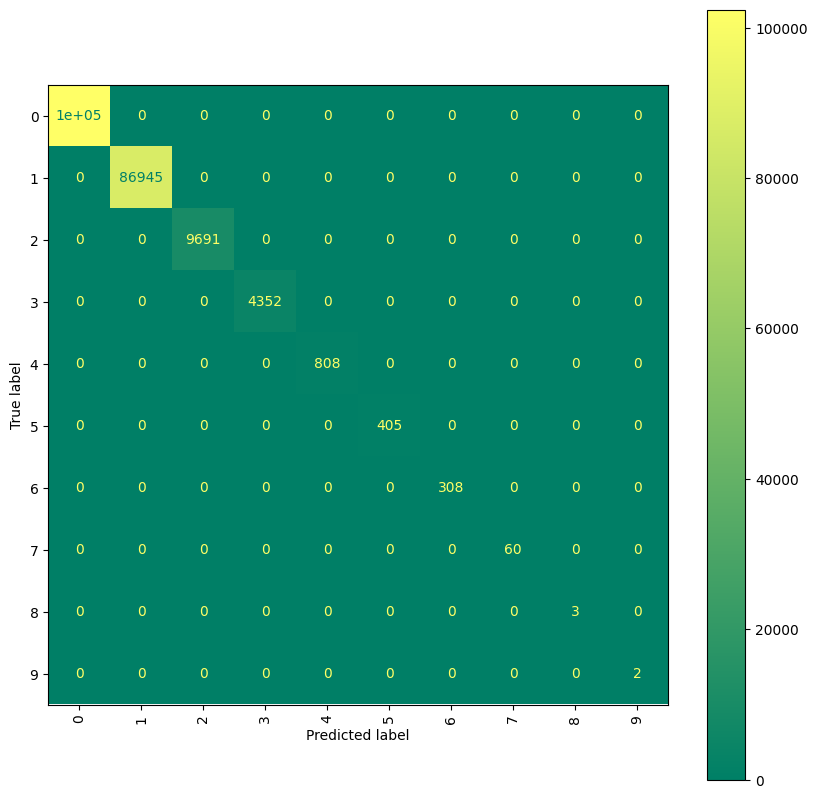

In [35]:
result_confusion_matrix = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = result_confusion_matrix)

# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = cm_display.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.show()

In [20]:
# Random Forest Classifier
print("---------- RandomForestClassifier ----------")
fit = RandomForestClassifier(random_state=1).fit(X_train, y_train)
y_predV2 = fit.predict(X_test)
scores = cross_val_score(fit, X, y, cv=5)
print("Completado con una precisión de: ", scores, "\n")
print(classification_report(y_test, y_predV2))
fmiV2 = fowlkes_mallows_score(y_test, y_predV2)
print("Fowlkes-Mallows Index:", fmiV2)


---------- RandomForestClassifier ----------
Completado con una precisión de:  [1. 1. 1. 1. 1.] 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    102428
           1       1.00      1.00      1.00     86945
           2       1.00      1.00      1.00      9691
           3       1.00      1.00      1.00      4352
           4       1.00      1.00      1.00       808
           5       1.00      1.00      1.00       405
           6       1.00      1.00      1.00       308
           7       1.00      1.00      1.00        60
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         2

    accuracy                           1.00    205002
   macro avg       1.00      1.00      1.00    205002
weighted avg       1.00      1.00      1.00    205002

Fowlkes-Mallows Index: 1.0


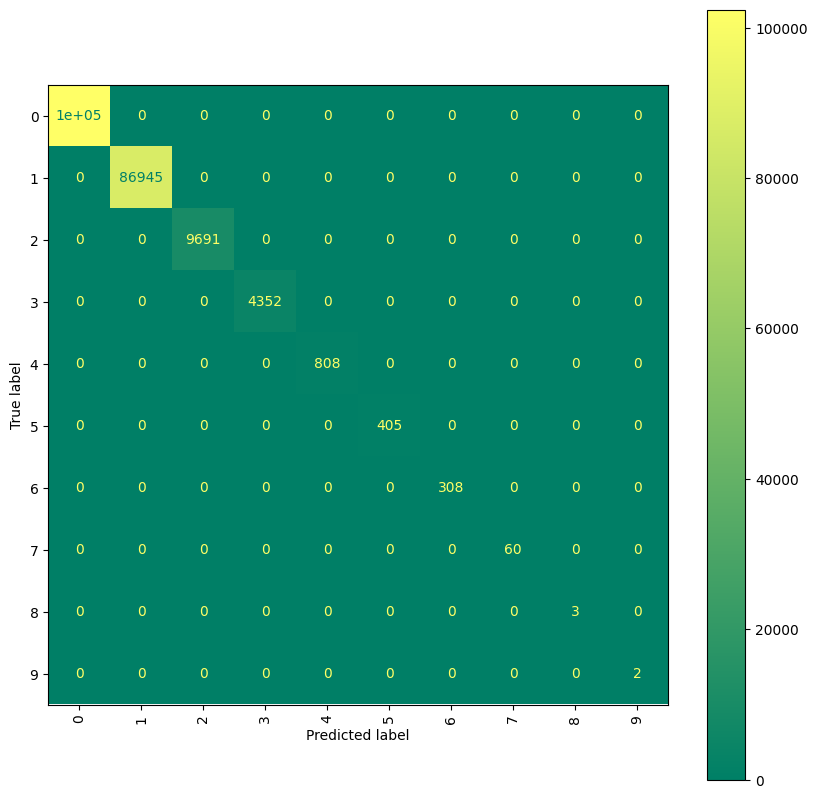

In [26]:
result_confusion_matrixV2 = confusion_matrix(y_test, y_predV2)
cm_displayV2 = ConfusionMatrixDisplay(confusion_matrix = result_confusion_matrixV2)

# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = cm_displayV2.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.show()

In [28]:
# SVM Classifier
print("---------- SupportVectorMachine ----------")
svm_classifier = SVC(kernel='linear').fit(X_train, y_train)
y_predV3 = svm_classifier.predict(X_test)
scores = cross_val_score(svm_classifier, X, y, cv=5)
print("Completado con una precisión de: ", scores, "\n")
print(classification_report(y_test, y_predV3))
fmiV3 = fowlkes_mallows_score(y_test, y_predV3)
print("Fowlkes-Mallows Index:", fmiV3)

---------- SupportVectorMachine ----------
